In [87]:
import pandas as pd
import numpy as np
from pathlib import Path
import holoviews as hv
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder

In [88]:
# Import the FNTC dataset into a Pandas Dataframe
fntc_df = pd.read_csv(
    Path("./Resources/fntc.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
fntc_df.head()

,open,high,low,close,volume
date,,,,,
2018-10-19 09:30:00,16.90,17.18,16.90,17.095,11522
2018-10-19 09:45:00,17.11,17.44,17.11,17.400,70593
2018-10-19 10:00:00,17.40,17.40,17.25,17.280,38885
2018-10-19 10:15:00,17.27,17.27,17.18,17.200,37046
2018-10-19 10:30:00,17.21,17.37,17.19,17.200,46874


In [89]:
# Filter the date index and close columns
signals_df = fntc_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2018-10-19 09:45:00,17.40,0.017841
2018-10-19 10:00:00,17.28,-0.006897
2018-10-19 10:15:00,17.20,-0.004630
2018-10-19 10:30:00,17.20,0.000000
2018-10-19 10:45:00,17.12,-0.004651


,close,Actual Returns
date,,
2020-09-04 14:45:00,6.250,0.003210
2020-09-04 15:00:00,6.250,0.000000
2020-09-04 15:15:00,6.275,0.004000
2020-09-04 15:30:00,6.255,-0.003187
2020-09-04 15:45:00,6.250,-0.000799


In [90]:
# Set the short window and long window
short_window = 7
long_window = 90

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2018-10-24 12:30:00,15.73,-0.002536,15.740000,16.412389
2018-10-24 12:45:00,15.77,0.002543,15.747143,16.394278
2018-10-24 13:00:00,15.75,-0.001268,15.757143,16.377278
2018-10-24 13:15:00,15.73,-0.001270,15.762143,16.360944
2018-10-24 13:30:00,15.72,-0.000636,15.751429,16.344500


,close,Actual Returns,SMA_Fast,SMA_Slow
date,,,,
2020-09-04 14:45:00,6.250,0.003210,6.222857,6.262833
2020-09-04 15:00:00,6.250,0.000000,6.228571,6.261889
2020-09-04 15:15:00,6.275,0.004000,6.240000,6.261167
2020-09-04 15:30:00,6.255,-0.003187,6.242143,6.260444
2020-09-04 15:45:00,6.250,-0.000799,6.247857,6.259556


In [91]:
# Initialize the new Signal column
signals_df['Signal'] = 0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = 0

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2018-10-24 12:30:00,15.73,-0.002536,15.740000,16.412389,0
2018-10-24 12:45:00,15.77,0.002543,15.747143,16.394278,1
2018-10-24 13:00:00,15.75,-0.001268,15.757143,16.377278,0
2018-10-24 13:15:00,15.73,-0.001270,15.762143,16.360944,0
2018-10-24 13:30:00,15.72,-0.000636,15.751429,16.344500,0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
date,,,,,
2020-09-04 14:45:00,6.250,0.003210,6.222857,6.262833,1
2020-09-04 15:00:00,6.250,0.000000,6.228571,6.261889,1
2020-09-04 15:15:00,6.275,0.004000,6.240000,6.261167,1
2020-09-04 15:30:00,6.255,-0.003187,6.242143,6.260444,0
2020-09-04 15:45:00,6.250,-0.000799,6.247857,6.259556,0


In [92]:
signals_df.reset_index(drop=True, inplace=True)

In [93]:
signals_df

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
0,15.730,-0.002536,15.740000,16.412389,0
1,15.770,0.002543,15.747143,16.394278,1
2,15.750,-0.001268,15.757143,16.377278,0
3,15.730,-0.001270,15.762143,16.360944,0
4,15.720,-0.000636,15.751429,16.344500,0
...,...,...,...,...,...
11974,6.250,0.003210,6.222857,6.262833,1
11975,6.250,0.000000,6.228571,6.261889,1
11976,6.275,0.004000,6.240000,6.261167,1
11977,6.255,-0.003187,6.242143,6.260444,0


In [94]:
# Define the target set y using the Signal column
y = signals_df["Signal"]

# Display a sample of y
y[:5]


0    0
1    1
2    0
3    0
4    0
Name: Signal, dtype: int64

In [95]:
X = signals_df.drop(columns=["Signal"])

X.head()

,close,Actual Returns,SMA_Fast,SMA_Slow
0,15.73,-0.002536,15.740000,16.412389
1,15.77,0.002543,15.747143,16.394278
2,15.75,-0.001268,15.757143,16.377278
3,15.73,-0.001270,15.762143,16.360944
4,15.72,-0.000636,15.751429,16.344500


In [96]:
# Split the preprocessed data into a training and testing dataset
# Assign the function a random_state equal to 1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [97]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [98]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

4

In [99]:
# Define the number of neurons in the output layer
number_output_neurons = 1

In [100]:
# Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 =  (number_input_features + 1) // 2 

# Review the number hidden nodes in the first layer
hidden_nodes_layer1

2

In [101]:
# Create the Sequential model instance
nn = Sequential()

In [102]:
# Add the first hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))


In [103]:
# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(1, activation="sigmoid"))


In [104]:
# Display the Sequential model summary
nn.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________


In [105]:
# Compile the Sequential model

nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [106]:
# Fit the model using 50 epochs and the training data

fit_model = nn.fit(X_train_scaled, y_train, epochs=50)


Epoch 1/50
281/281 [==============================] - 1s 892us/step - loss: 0.7608 - accuracy: 0.5124
Epoch 2/50
281/281 [==============================] - 0s 1ms/step - loss: 0.6277 - accuracy: 0.7362
Epoch 3/50
281/281 [==============================] - 0s 976us/step - loss: 0.5342 - accuracy: 0.8102
Epoch 4/50
281/281 [==============================] - 0s 937us/step - loss: 0.4659 - accuracy: 0.8744
Epoch 5/50
281/281 [==============================] - 0s 992us/step - loss: 0.4094 - accuracy: 0.9127
Epoch 6/50
281/281 [==============================] - 0s 1ms/step - loss: 0.3617 - accuracy: 0.9338
Epoch 7/50
281/281 [==============================] - 0s 907us/step - loss: 0.3212 - accuracy: 0.9554
Epoch 8/50
281/281 [==============================] - 0s 798us/step - loss: 0.2869 - accuracy: 0.9661
Epoch 9/50
281/281 [==============================] - 0s 842us/step - loss: 0.2575 - accuracy: 0.9735
Epoch 10/50
281/281 [==============================] - 0s 774us/step - loss: 0.2322 - 

In [107]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)

# Display the model loss and accuracy results

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

94/94 - 0s - loss: 0.0129 - accuracy: 1.0000
Loss: 0.012923181988298893, Accuracy: 1.0


In [84]:
model_plot = pd.DataFrame(fit_model.history, index=range(1, len(fit_model.history["loss"]) + 1))


<AxesSubplot:>

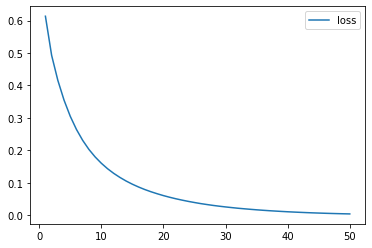

In [85]:
model_plot.plot(y="loss")

<AxesSubplot:>

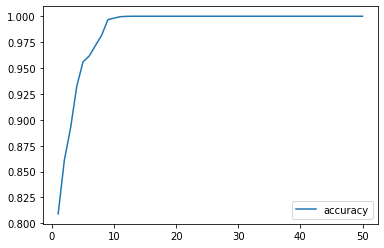

In [86]:
model_plot.plot(y="accuracy")